In [1]:
import os


# Environment configuration for a clean Jupyter environment with minimal logs and GPU setup.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "3"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_TRT_ALLOW_ENGINE_NATIVE_SEGMENT_EXECUTION"] = "false"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GRPC_CPP_LOG_LEVEL"] = "ERROR"

# Set visible GPU devices before importing TensorFlow
USE_ONLY_GPU_INDEX = 0
from tensorflow.python.framework import config as tf_config

physical_devices = tf_config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf_config.set_visible_devices(physical_devices[USE_ONLY_GPU_INDEX], 'GPU')
        tf_config.set_memory_growth(physical_devices[USE_ONLY_GPU_INDEX], True)
    except RuntimeError as e:
        print("GPU config error:", e)
else:
    raise RuntimeError("No GPU found!")

# Import TensorFlow and silence warnings
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

print("GPUs available:", tf.config.list_logical_devices('GPU'))

GPUs available: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import load, dump

from backtesting import Backtest, Strategy
from bokeh.io import show, output_notebook, save

from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import (Input, MultiHeadAttention, Dropout, LayerNormalization,
                                     GlobalAveragePooling1D, Dense, Conv1D, MaxPooling1D,
                                     Flatten, GRU, SimpleRNN)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
import matplotlib.pyplot as plt

from backtesting import Strategy

from bokeh.io import save, reset_output


from IPython.utils import io


import time

import os
import pandas as pd
import re
from datetime import datetime
import markdown


import os
import markdown
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report


import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os
import time
import io
import re
import contextlib
import pandas as pd



Loading BokehJS ...

In [3]:
PROCESSED_DATA = os.path.join("data", "processed-data")
RESULT_DATA_DIR = os.path.join("model-result-data")

In [4]:
# File paths for saving results
os.makedirs(RESULT_DATA_DIR, exist_ok=True)

## Data

In [5]:
def create_target_df(features_df, asset_label):
    target_df = pd.DataFrame(index=features_df.index)
    target_df[f'{asset_label}_Close_1m_later'] = features_df['Close'].shift(-1)
    target_df.dropna(inplace=True)
    return target_df


In [6]:
def extract_target_df(features_df, label = "target"):
    if label not in features_df.columns:
        raise ValueError(f"Label column '{label}' not found in DataFrame. Available columns: {list(features_df.columns)}")
    target_df = features_df[[label]].copy()
    features_df = features_df.drop(columns=[label])
    return features_df, target_df

In [7]:

def _clean(df, tz="UTC"):
    for c in ("minute_id", "Date_dt", "datetime", "timestamp"):
        if c in df.columns:
            df = df.rename(columns={c: "date"})
            break
    if pd.api.types.is_integer_dtype(df["date"]):
        df["date"] = pd.to_datetime(
            df["date"].astype(str), format="%Y%m%d%H%M", utc=True, errors="coerce"
        )
    else:
        df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")
    df = df.set_index("date").sort_index()
    return df.tz_convert(tz) if tz else df

In [8]:
def crypto_data_io(
    asset,
    action="load",
    fmt="auto",
    root=PROCESSED_DATA,
    tz="UTC",
    engine="pyarrow",
):
    asset = asset.lower()
    csv_file = os.path.join(root, f"{asset}_1min_with_features.csv.gz")
    pq_file = os.path.join(root, f"{asset}_1min_with_features.parquet")

    if fmt == "auto":
        fmt = "parquet" if os.path.exists(pq_file) else "csv"

    if action == "load":
        if fmt == "parquet":
            df = pd.read_parquet(pq_file, engine=engine)
        elif fmt == "csv":
            df = pd.read_csv(csv_file, compression="gzip")
        else:
            raise ValueError
        df = _clean(df, tz=tz)

    elif action == "save":
        df = _clean(pd.read_csv(csv_file, compression="gzip"), tz=tz)
        if fmt == "parquet":
            df.to_parquet(pq_file, index=True, compression="snappy", engine=engine)
        elif fmt == "csv":
            clean_csv = os.path.splitext(csv_file)[0] + ".clean.csv.gz"
            df.to_csv(clean_csv, compression="gzip")
        else:
            raise ValueError
    else:
        raise ValueError

    return df, create_target_df(df, asset)

In [9]:
btc_df_features, btc_targets = crypto_data_io("btc", action="load")

In [10]:
eth_df_features, eth_targets = crypto_data_io("eth", action="load")


## Constants & Functions

In [11]:

def setup_directories():
    os.makedirs("plots", exist_ok=True)
    os.makedirs("models", exist_ok=True)
    os.makedirs("logs", exist_ok=True)
    return "Done"

In [12]:
def get_data_subset(features_df, targets_df, target_col, data_percent=0.01):
    # Intersect indices from features_df and targets_df, sorted
    common_index = features_df.index.intersection(targets_df.index).sort_values()
    
    subset_size = int(len(common_index) * data_percent)
    subset_dates = common_index[:subset_size]

    print("Total data values in intersection:", len(common_index))
    print("Number of data points to use:", subset_size)

    X = features_df.loc[subset_dates].copy()
    y = targets_df.loc[subset_dates, target_col].copy()

    # Create a combined subset dataframe
    subset = X.copy()
    subset[target_col] = y

    # Convert string index in the form YYYYMMDDHHMM to datetime
    date_series = pd.to_datetime(subset.index, format='%Y%m%d%H%M')

    subset.index = date_series
    X.index = date_series

    # Print diagnostic info
    print("Start of subset:", date_series[0] if not date_series.empty else "N/A")
    print("End of subset:", date_series[-1] if not date_series.empty else "N/A")

    return X, y, subset, date_series

In [13]:
def scale_features(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler


In [14]:

def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    indices = []  # will store i+time_steps for labeling
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
        indices.append(i + time_steps)
    return np.array(Xs), np.array(ys), np.array(indices)


In [ ]:
def train_test_split_sequences(X_seq, y_seq, indices, train_ratio=0.8):
    train_size = int(len(X_seq) * train_ratio)

    X_train = X_seq[:train_size]
    y_train = y_seq[:train_size]
    idx_train = indices[:train_size]

    X_test  = X_seq[train_size:]
    y_test  = y_seq[train_size:]
    idx_test = indices[train_size:]

    return X_train, y_train, X_test, y_test, idx_train, idx_test

def format_percent_string(p):
    return f"{p * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")

In [16]:
def train_model(model, X_train, y_train, X_val, y_val, data_percent=0.01, epochs=20, model_name="model", asset="btc"):
    
    percent_display = format_percent_string(data_percent)
    model_prefix = f"{model_name}_{asset.lower()}"
    
    model_filename = f"{model_prefix}_model_{percent_display}pct.h5"
    log_filename = f"{model_prefix}_log_{percent_display}pct.csv"

    checkpoint = ModelCheckpoint(os.path.join("models", model_filename), monitor="val_loss", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    csv_logger = CSVLogger(os.path.join("logs", log_filename))

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, early_stop, csv_logger],
        verbose=1
    )
    return history

In [36]:
def print_metrics(y_test, y_pred, *, data_percent=0.01,
                  model_name="model", dataset_name="asset"):
    import os, pandas as pd, numpy as np
    from sklearn.metrics import (accuracy_score, precision_score,
                                 recall_score, f1_score,
                                 mean_squared_error, mean_absolute_error)

    test_sig = np.sign(np.diff(y_test.ravel()))
    pred_sig = np.sign(np.diff(y_pred.ravel()))

    acc  = accuracy_score(test_sig, pred_sig)
    prec = precision_score(test_sig, pred_sig, average='macro')
    rec  = recall_score(test_sig, pred_sig, average='macro')
    f1   = f1_score(test_sig, pred_sig, average='macro')
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)

    print(f"{data_percent*100:.1f}% | acc {acc:.4f}  prec {prec:.4f}  "
          f"rec {rec:.4f}  f1 {f1:.4f}  mse {mse:.4f}  rmse {rmse:.4f}  mae {mae:.4f}")

    os.makedirs(RESULT_DATA_DIR, exist_ok=True)
    fname = f"{dataset_name}_{model_name}_{format_percent_string(data_percent)}pct_metrics.csv"
    pd.DataFrame([dict(dataset=dataset_name, model=model_name,
                       data_pct=data_percent, accuracy=acc, precision=prec,
                       recall=rec, f1=f1, mse=mse, rmse=rmse, mae=mae)]
                ).to_csv(os.path.join(RESULT_DATA_DIR, fname), index=False)

In [18]:
def plot_loss(history, plots_dir="plots", data_percent=0.01, model_name="gru", dataset_name="btc"):
    # Ensure the directory exists
    os.makedirs(plots_dir, exist_ok=True)

    # Format percent strings
    percent_display_filename = format_percent_string(data_percent) 
    percent_display_title = f"{data_percent * 100:.2f}"

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Loss Curve | Model: {model_name.upper()} | Dataset: {dataset_name.upper()} | Data: {percent_display_title}%")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.legend()
    plt.grid(True)

    # Save plot
    filename = f"loss_curve_{model_name}_{dataset_name}_{percent_display_filename}pct.png"
    loss_curve_path = os.path.join(plots_dir, filename)
    plt.savefig(loss_curve_path)
    plt.show()

    print(f"Loss curve saved to: {loss_curve_path}")


In [43]:
def plot_predictions(y_test, y_pred, date_series=None, plots_dir="plots", data_percent=0.01,
                     model_name="gru", dataset_name="btc", last_n=200):

    # Ensure directories exist
    os.makedirs(plots_dir, exist_ok=True)
    os.makedirs(RESULT_DATA_DIR, exist_ok=True)

    # Fallback for date series
    if date_series is None:
        date_series = pd.RangeIndex(start=0, stop=len(y_test))

    # Format percent display
    percent_display_filename = format_percent_string(data_percent)
    percent_display_title = f"{data_percent * 100:.2f}"

    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        "Date": date_series,
        "Actual": y_test,
        "Predicted": y_pred.flatten()
    })

    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(comparison_df["Date"].iloc[-last_n:], comparison_df["Actual"].iloc[-last_n:], label="Actual")
    plt.plot(comparison_df["Date"].iloc[-last_n:], comparison_df["Predicted"].iloc[-last_n:], label="Predicted", linestyle="--")
    plt.title(f"{dataset_name.upper()} Prediction | Model: {model_name.upper()} | Data: {percent_display_title}% | Last {last_n} Samples")
    plt.xlabel("Date" if date_series is not None else "Index")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)

    # Save plot
    filename = f"prediction_plot_{model_name}_{dataset_name}_{percent_display_filename}pct.png"
    plot_path = os.path.join(plots_dir, filename)
    plt.savefig(plot_path)
    plt.show()
    print(f"Prediction plot saved to: {plot_path}")

    # Save comparison CSV
    result_file = os.path.join(RESULT_DATA_DIR, f"{model_name}_{dataset_name}_{percent_display_filename}pct_comparison.csv")
    comparison_df.to_csv(result_file, index=False)
    print(f"Comparison CSV saved to: {result_file}")

    return comparison_df


In [20]:
def save_model_and_scaler(model, scaler, model_name: str, dataset_name: str, data_percent: float, model_ext: str = "h5"):
    os.makedirs("models", exist_ok=True)
    percent_str = f"{data_percent * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")
    model_filename = f"{model_name}_{dataset_name}_model_{percent_str}pct.{model_ext}"
    scaler_filename = f"{model_name}_{dataset_name}_scaler_{percent_str}pct.pkl"

    model_path = Path("models") / model_filename
    scaler_path = Path("models") / scaler_filename

    if model_ext in ['h5', 'keras']:
        save_model(model, str(model_path))
    else:
        dump(model, model_path)

    dump(scaler, scaler_path)

    print("Model saved to:", model_path.resolve().relative_to(Path.cwd()))
    print("Scaler saved to:", scaler_path.resolve().relative_to(Path.cwd()))


In [21]:
def load_model_and_scaler(model_name: str, dataset_name: str, data_percent: float, model_ext: str = "h5"):
    percent_str = f"{data_percent * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")

    model_filename = f"{model_name}_{dataset_name}_model_{percent_str}pct.{model_ext}"
    scaler_filename = f"{model_name}_{dataset_name}_scaler_{percent_str}pct.pkl"

    model_path = Path("models") / model_filename
    scaler_path = Path("models") / scaler_filename

    if model_ext in ['h5', 'keras']:
        model = load_model(model_path)
    else:
        model = load(model_path)

    scaler = load(scaler_path)

    print("Model loaded from:", model_path.resolve().relative_to(Path.cwd()))
    print("Scaler loaded from:", scaler_path.resolve().relative_to(Path.cwd()))

    return model, scaler

In [22]:
class MLStrategy(Strategy):
    stop_loss_pct = 0.0
    def init(self):
        self.signal = self.data.Signal
        num_pos_signals = int((self.signal == 1).sum())
        num_neg_signals = int((self.signal == -1).sum())
        print(f"Found {num_pos_signals} +1 signals and {num_neg_signals} -1 signals in the data.")
        self.opened_first_time = False

    def next(self):
        # Get the current bar's index and use it to fetch the full data (OHLC and Signal) from the original DataFrame.
        current_idx = self.data.index[-1]
        current_close = self.data.df.loc[current_idx, 'Close']
        current_signal = self.data.df.loc[current_idx, 'Signal']
        current_profit = 0.0
        if self.position and hasattr(self, 'my_entry_price'):
            if self.position.is_long:
                current_profit = current_close - self.my_entry_price
            elif self.position.is_short:
                current_profit = self.my_entry_price - current_close
    
        # 1) For the first trade: only enter when the signal is +1.
        if not self.opened_first_time:
            if current_signal == 1:
                self.opened_first_time = True
                if self.stop_loss_pct > 0:
                    stop_loss_price = current_close * (1 - self.stop_loss_pct)
                    self.buy(sl=stop_loss_price)
                else:
                    self.buy()
                # Record our entry price for subsequent profit calculations.
                self.my_entry_price = current_close
            return  # Exit early until first trade is taken.
    
        # 2) For subsequent bars, adjust positions based on the signal.
        if current_signal == 1:
            # If not currently long, flip to long (close any short and go long).
            if not self.position.is_long:
                self.position.close()
                if self.stop_loss_pct > 0:
                    stop_loss_price = current_close * (1 - self.stop_loss_pct)
                    self.buy(sl=stop_loss_price)
                else:
                    self.buy()
                # Update the entry price after the trade is executed.
                self.my_entry_price = current_close
    
        elif current_signal == -1:
            # Only reverse to short if there's an open long position that is already in profit.
            if self.position and self.position.is_long and current_profit > 0:
                self.position.close()
                if self.stop_loss_pct > 0:
                    stop_loss_price = current_close * (1 + self.stop_loss_pct)
                    self.sell(sl=stop_loss_price)
                else:
                    self.sell()
                # Update the entry price for the new short position.
                self.my_entry_price = current_close

    def stop(self):
        # Force-close any open position at the end of the backtest
        self.position.close()


In [64]:
# def save_interactive_chart(bt_ ,html_filename):
#     with io.capture_output():
#         plot_obj = bt_.plot()
#     save(plot_obj, filename=html_filename)
#     print("Interactive chart saved to:", html_filename)

from IPython.utils import io as ipy_io

def save_interactive_chart(bt_, html_filename):
    with ipy_io.capture_output() as captured:
        plot_obj = bt_.plot()
    save(plot_obj, filename=html_filename)


In [ ]:
def run_backtest(
    df_bt,
    initial_cash=10_000,
    model_name="gru",
    dataset_name="btc",
    data_percent=0.01,
    stop_loss_pct=0.0
):
    print("Setting up Backtest object...")
    bt = Backtest(
        df_bt,
        MLStrategy,
        cash=initial_cash,
        commission=0.0,
        exclusive_orders=True
    )
    
    print("Running backtest engine...")
    stats = bt.run(stop_loss_pct=stop_loss_pct)
    print(stats)
    
    trades_df = getattr(stats, 'trades', None) or getattr(stats, '_trades', None)
    if trades_df is not None:
        n_trades = len(trades_df)
        n_closed_trades = trades_df['ExitPrice'].notna().sum()
        n_open_trades = trades_df['ExitPrice'].isna().sum()
        
        print("\nTrade Details:")
        print(f"Number of trades:       {n_trades}")
        print(f"Number of closed trades:{n_closed_trades}")
        print(f"Number of open trades:  {n_open_trades}")
    
    print("Saving backtest plot to HTML...")
    from bokeh.io import save
    import os
    
    # Format stop loss as percentage string for filenames
    stop_str = format_percent_string(stop_loss_pct)  # e.g. 0.025 becomes 'sl0025'
    result_dir = os.path.join(
        "results",
        f"{model_name}_{dataset_name}_{format_percent_string(data_percent)}pct_{stop_str}stloss"
    )
    os.makedirs(result_dir, exist_ok=True)
    #have to save this outside, as this was making the notebook crash
    html_filename = os.path.join(result_dir, "backtest_plot.html")
    save_interactive_chart(bt, html_filename)
    csv_filename = os.path.join(result_dir, "backtest_stats.csv")
    stats.to_csv(csv_filename)
    print("Backtest stats saved to:", csv_filename)
    return stats

## Initial Testing - Model Pipeline

Some of the functions differ from the initial testing, as they were updated.

In [17]:
# Variables for initial testing

DATA_PERCENT = 0.001
TIME_STEPS = 30
TARGET_COL = "btc_Close_1m_later"


In [18]:
setup_directories()

'Done'

In [33]:
X_raw, y_raw, btc_subset, date_series = get_data_subset(btc_df_features, btc_targets, TARGET_COL, DATA_PERCENT)


Total data values in intersection: 6283462
Number of data points to use: 6283
Start of subset: 2012-01-31 10:45:00+00:00
End of subset: 2012-03-27 18:37:00+00:00


In [34]:
X_scaled, scaler = scale_features(X_raw)


In [36]:
X_seq, y_seq, seq_indices = create_sequences(X_scaled, y_raw.values, TIME_STEPS)

In [40]:
X_train, y_train, X_test, y_test, idx_train, idx_test = train_test_split_sequences(X_seq, y_seq, seq_indices)

In [41]:
model = build_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))

In [42]:
history = train_model(model, X_train, y_train, X_test, y_test, DATA_PERCENT)

Epoch 1/20
149/157 [===========================>..] - ETA: 0s - loss: 1.4194
Epoch 1: val_loss improved from inf to 0.00846, saving model to models\model_btc_model_0_1pct.h5
157/157 [==============================] - 19s 11ms/step - loss: 1.3627 - val_loss: 0.0085
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 0.1745
Epoch 2: val_loss improved from 0.00846 to 0.00725, saving model to models\model_btc_model_0_1pct.h5
157/157 [==============================] - 1s 6ms/step - loss: 0.1748 - val_loss: 0.0072
Epoch 3/20
155/157 [============================>.] - ETA: 0s - loss: 0.1398
Epoch 3: val_loss did not improve from 0.00725
157/157 [==============================] - 1s 6ms/step - loss: 0.1396 - val_loss: 0.0107
Epoch 4/20
148/157 [===========================>..] - ETA: 0s - loss: 0.1309
Epoch 4: val_loss did not improve from 0.00725
157/157 [==============================] - 1s 5ms/step - loss: 0.1311 - val_loss: 0.0123
Epoch 5/20
150/157 [======================

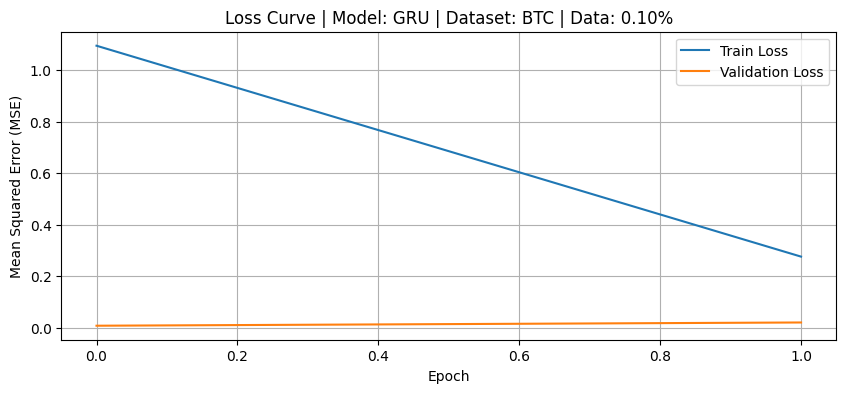

Loss curve saved to: plots\loss_curve_gru_btc_0_1pct.png


In [124]:
plot_loss(history, data_percent=DATA_PERCENT, model_name="gru", dataset_name="btc")

In [44]:
y_pred = model.predict(X_test)

40/40 [==============================] - 0s 5ms/step


In [78]:
len(y_test)

1251

In [77]:
len(date_series)

6283

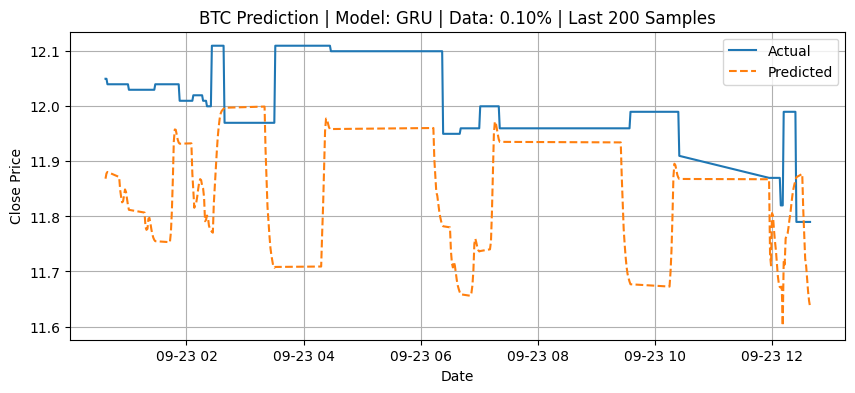

Prediction plot saved to: plots\prediction_plot_gru_btc_0_1pct.png
Comparison CSV saved to: model-result-data\gru_btc_comparison_0_1pct.csv


In [126]:
comparison_df = plot_predictions(
    y_test, 
    y_pred, 
    date_series=date_series[idx_test], 
    data_percent=DATA_PERCENT, 
    model_name="gru", 
    dataset_name="btc"
)


In [83]:
print_metrics(y_test, y_pred, data_percent = DATA_PERCENT, model_name="gru", dataset_name="btc")

0.1% | acc 0.0504  prec 0.0344  rec 0.3315  f1 0.0621  mse 0.0065  rmse 0.0808  mae 0.0679


In [84]:
save_model_and_scaler(model, scaler, model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)

Model saved to: models\gru_btc_model_0_1pct.h5
Scaler saved to: models\gru_btc_scaler_0_1pct.pkl


In [85]:
model, scaler = load_model_and_scaler(model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)

Model loaded from: models\gru_btc_model_0_1pct.h5
Scaler loaded from: models\gru_btc_scaler_0_1pct.pkl


In [88]:
signals = np.sign(np.diff(y_pred.flatten(), prepend=y_pred.flatten()[0]))
signals[signals == 0] = 1

# Construct df_bt
df_bt = pd.DataFrame({
    'Open': y_test.flatten(),
    'High': y_test.flatten(),
    'Low': y_test.flatten(),
    'Close': y_test.flatten(),
    'Signal': signals,
}, index=date_series[idx_test])


In [91]:

# Call backtest properly
stats = run_backtest(
    df_bt,
    initial_cash=100_000,
    model_name="gru",
    dataset_name="btc",
    data_percent=DATA_PERCENT
)


Setting up Backtest object...
Running backtest engine...
Found 701 +1 signals and 550 -1 signals in the data.


Start                     2012-03-16 00:59...
End                       2012-03-27 18:37...
Duration                     11 days 17:38:00
Exposure Time [%]                    12.78977
Equity Final [$]                     88661.93
Equity Peak [$]                     100743.48
Return [%]                          -11.33807
Buy & Hold Return [%]               -11.33829
Return (Ann.) [%]                   -97.70214
Volatility (Ann.) [%]                 1.22636
CAGR [%]                            -97.63188
Sharpe Ratio                        -79.66822
Sortino Ratio                        -2.03444
Calmar Ratio                         -6.01768
Alpha [%]                            -0.00002
Beta                                  0.99998
Max. Drawdown [%]                   -16.23585
Avg. Drawdown [%]                    -4.61601
Max. Drawdown Duration        9 days 03:33:00
Avg. Drawdown Duration        2 days 05:05:00
# Trades                                    8
Win Rate [%]                      

## Testing - Putting it all together

In [93]:
asset="btc" 
model_function=build_gru_model
model_name="gru"
data_percent= 0.01
initial_cash=100_000 
epochs=2
time_steps = 30
targets_df = btc_targets
features_df= btc_df_features

Loading data for asset: btc
Total data values in intersection: 6283462
Number of data points to use: 62834
Start of subset: 2012-01-31 10:45:00+00:00
End of subset: 2012-09-23 12:39:00+00:00
Data subset shape: (62834, 44), (62834,)
Extracting OHLC columns...
Normalizing features...
Creating sequences...
Total sequences created: 62804
Splitting data into training and testing sets...
Train size: (50243, 30, 40), Test size: (12561, 30, 40)
Building model...
Training model...
Epoch 1/2
1570/1571 [============================>.] - ETA: 0s - loss: 1.0944
Epoch 1: val_loss improved from inf to 0.00843, saving model to models\gru_btc_model_1pct.h5
1571/1571 [==============================] - 10s 6ms/step - loss: 1.0943 - val_loss: 0.0084
Epoch 2/2
1565/1571 [============================>.] - ETA: 0s - loss: 0.2762
Epoch 2: val_loss did not improve from 0.00843
1571/1571 [==============================] - 8s 5ms/step - loss: 0.2764 - val_loss: 0.0210
Plotting training loss...


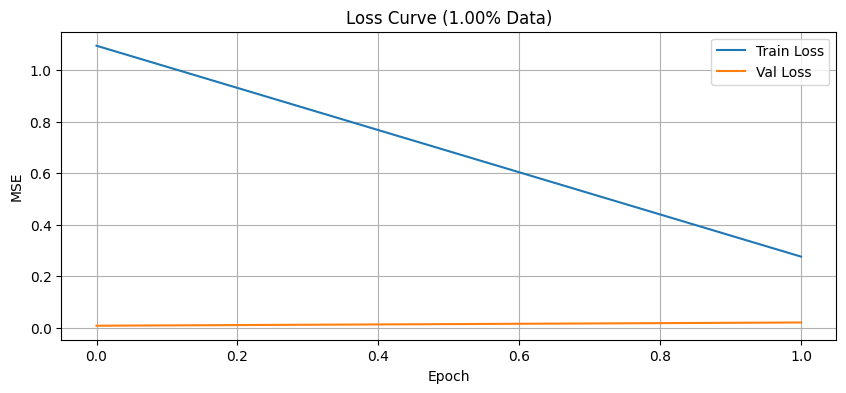

Loss curve saved to: plots\loss_curve_gru_btc_1pct.png
Generating predictions...
393/393 [==============================] - 1s 2ms/step
Predictions shape: (12561, 1)
Plotting predictions and saving comparison CSV...
Prediction plot saved to: plots\prediction_plot_gru_btc_1pct.png


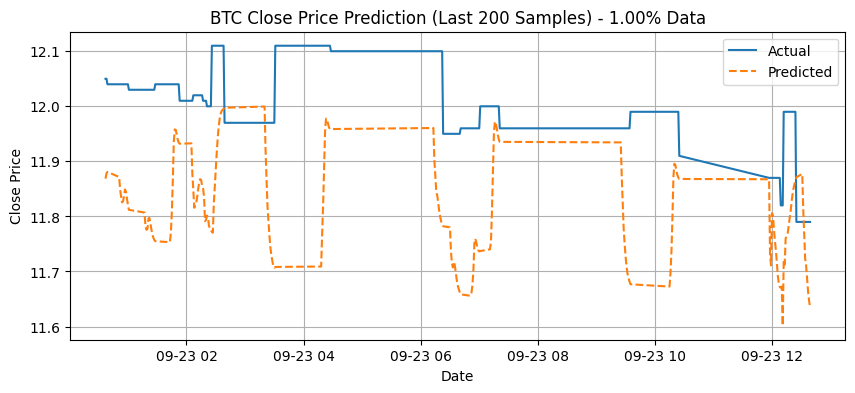

Comparison CSV saved to: model-result-data\gru_btc_comparison_1pct.csv
Printing evaluation metrics...
1.0% | acc 0.0575  prec 0.3708  rec 0.3044  f1 0.0666  mse 0.0210  rmse 0.1449  mae 0.1225
Saving model and scaler...
Model saved to: models\gru_btc_model_1pct.h5
Scaler saved to: models\gru_btc_scaler_1pct.pkl
Running backtest...
Setting up Backtest object...
Running backtest engine...
Found 5208 +1 signals and 7353 -1 signals in the data.


Start                     2012-08-28 02:48...
End                       2012-09-23 12:39...
Duration                     26 days 09:51:00
Exposure Time [%]                    89.10915
Equity Final [$]                    107747.09
Equity Peak [$]                     115247.46
Return [%]                            7.74709
Buy & Hold Return [%]                  9.3692
Return (Ann.) [%]                    64.19386
Volatility (Ann.) [%]                82.08911
CAGR [%]                            180.44943
Sharpe Ratio                            0.782
Sortino Ratio                          1.9067
Calmar Ratio                          4.18397
Alpha [%]                            -1.45957
Beta                                  0.98265
Max. Drawdown [%]                   -15.34281
Avg. Drawdown [%]                     -1.7583
Max. Drawdown Duration       15 days 05:34:00
Avg. Drawdown Duration        0 days 16:34:00
# Trades                                   80
Win Rate [%]                      

In [108]:
setup_directories()

# Constants
asset = "btc"
target_col = f"{asset}_Close_1m_later"

print(f"Loading data for asset: {asset}")

X_raw, y_raw, merged_subset, date_series = get_data_subset(
    features_df, targets_df, target_col, data_percent
)

print(f"Data subset shape: {X_raw.shape}, {y_raw.shape}")

# Extract real OHLC before scaling
print("Extracting OHLC columns...")
df_ohlc = merged_subset[["Open", "High", "Low", "Close"]].copy()

# Drop OHLC columns from X_raw if they shouldn't be scaled
X_no_ohlc = X_raw.drop(columns=["Open", "High", "Low", "Close"], errors='ignore')

print("Normalizing features...")
X_scaled, scaler = scale_features(X_no_ohlc)

print("Creating sequences...")
X_seq, y_seq, seq_indices = create_sequences(X_scaled, y_raw.values, time_steps)
print(f"Total sequences created: {len(X_seq)}")

print("Splitting data into training and testing sets...")
X_train, y_train, X_test, y_test, idx_train, idx_test = train_test_split_sequences(X_seq, y_seq, seq_indices)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

print("Building model...")
model = model_function(input_shape=(X_train.shape[1], X_train.shape[2]))

print("Training model...")
history = train_model(model, X_train, y_train, X_test, y_test, data_percent, epochs, model_name=model_name, asset=asset)

print("Plotting training loss...")
plot_loss(history, data_percent=data_percent, model_name=model_name, dataset_name=asset)

print("Generating predictions...")
y_pred = model.predict(X_test)
print(f"Predictions shape: {y_pred.shape}")

print("Plotting predictions and saving comparison CSV...")
comparison_df = plot_predictions(
    y_test,
    y_pred,
    date_series=date_series[idx_test],
    data_percent=data_percent,
    model_name=model_name,
    dataset_name=asset
)

print("Printing evaluation metrics...")
print_metrics(y_test, y_pred, data_percent=data_percent, model_name=model_name, dataset_name=asset)

print("Saving model and scaler...")
save_model_and_scaler(model, scaler, model_name=model_name, dataset_name=asset, data_percent=data_percent)

# Backtesting Preparation
signals = np.sign(np.diff(y_pred.flatten(), prepend=y_pred.flatten()[0]))
signals[signals == 0] = 1

# Prepare dataframe for backtesting
df_bt = pd.DataFrame({
    'Open': df_ohlc.iloc[idx_test]['Open'],
    'High': df_ohlc.iloc[idx_test]['High'],
    'Low': df_ohlc.iloc[idx_test]['Low'],
    'Close': df_ohlc.iloc[idx_test]['Close'],
    'Signal': signals
}, index=date_series[idx_test])

print("Running backtest...")
stats = run_backtest(
    df_bt,
    initial_cash=initial_cash,
    model_name=model_name,
    dataset_name=asset,
    data_percent=data_percent
)

print("Pipeline completed successfully.")


In [99]:
df_ohlc_test = df_ohlc.iloc[idx_test].copy()

temp_df = df_ohlc_test[['Close']].copy()
temp_df['y_pred'] = y_pred.flatten()
temp_df['diff'] = temp_df['y_pred'] - temp_df['Close']
temp_df['Signal'] = np.where(temp_df['y_pred'] > temp_df['Close'], 1, -1)

print(temp_df[temp_df['Signal'].isin([1, -1])].sample(n=20))


                           Close     y_pred      diff  Signal
date                                                         
2012-09-15 11:09:00+00:00  11.59  11.634052  0.044052       1
2012-08-31 19:51:00+00:00  10.28  10.356412  0.076412       1
2012-09-13 15:48:00+00:00  11.35  11.362631  0.012631       1
2012-09-10 04:18:00+00:00  10.95  11.044332  0.094332       1
2012-08-31 13:11:00+00:00  10.40  10.464032  0.064032       1
2012-09-06 08:26:00+00:00  10.70  10.778274  0.078274       1
2012-09-17 00:46:00+00:00  11.56  11.623814  0.063814       1
2012-09-07 21:14:00+00:00  11.09  10.912265 -0.177735      -1
2012-09-13 14:17:00+00:00  11.35  11.420604  0.070604       1
2012-09-20 07:53:00+00:00  12.33  12.226871 -0.103129      -1
2012-09-14 08:07:00+00:00  11.32  11.274605 -0.045395      -1
2012-09-23 07:18:00+00:00  12.00  12.016202  0.016202       1
2012-09-07 17:30:00+00:00  10.94  11.013576  0.073576       1
2012-08-30 22:15:00+00:00  10.66  10.741309  0.081309       1
2012-08-

In [102]:
y_pred_s = pd.Series(y_pred.flatten(), index=df_ohlc_test.index)

y_pred_shifted = y_pred_s.shift(1)

df_ohlc_test["Signal"] = np.where(
    y_pred_shifted > df_ohlc_test["Close"],
    1,
    -1
)

print("Signal distribution:")
print(df_ohlc_test["Signal"].value_counts())

stats = run_backtest(
    df_bt=df_ohlc_test,
    initial_cash=initial_cash,
    model_name=model_name,
    dataset_name=asset,
    data_percent=data_percent,
    stop_loss_pct=0.01 # this stop loss helped in cleaning some of the noice. This ensures if the model is wrong somewhere, the money is pulled back. 

)


Signal distribution:
Signal
 1    9096
-1    3465
Name: count, dtype: int64
Setting up Backtest object...
Running backtest engine...
Found 9096 +1 signals and 3465 -1 signals in the data.


Start                     2012-08-28 02:48...
End                       2012-09-23 12:39...
Duration                     26 days 09:51:00
Exposure Time [%]                    98.47146
Equity Final [$]                  332960.2247
Equity Peak [$]                   332960.2247
Return [%]                          232.96022
Buy & Hold Return [%]                  9.3692
Return (Ann.) [%]            1213175021.74987
Volatility (Ann.) [%]        2327631129.27178
CAGR [%]                     1658140761.42102
Sharpe Ratio                          0.52121
Sortino Ratio                  59943306.13632
Calmar Ratio                   201740093.0184
Alpha [%]                           226.80691
Beta                                  0.65676
Max. Drawdown [%]                    -6.01355
Avg. Drawdown [%]                    -1.48319
Max. Drawdown Duration        3 days 23:15:00
Avg. Drawdown Duration        0 days 05:52:00
# Trades                                  758
Win Rate [%]                      

## Optomized Funtions

In [25]:
def train_and_predict(asset, model_function, data_percent, model_name=None, epochs=20, time_steps=30, other_df=None):
    print(f"Loading data for asset: {asset}")
    if asset.lower() == "btc":
        features_df = btc_df_features
        targets_df = btc_targets
        target_col = "btc_Close_1m_later"
    elif asset.lower() == "eth":
        features_df = eth_df_features
        targets_df = eth_targets
        target_col = "eth_Close_1m_later"
    elif other_df is not None and not other_df.empty:
        features_df, targets_df = extract_target_df(other_df, 'target')
        target_col = "target"
    else:
        raise ValueError("Asset must be either 'btc' or 'eth' or a df should be given.")
    
    print("Subsetting data...")
    X_raw, y_raw, merged_subset, date_series = get_data_subset(features_df, targets_df, target_col, data_percent)
    print(f"Data subset shape: {X_raw.shape}, {y_raw.shape}")
    df_ohlc = merged_subset[["Open", "High", "Low", "Close"]].copy()
    X_no_ohlc = X_raw.drop(columns=["Open", "High", "Low", "Close"], errors='ignore')
    
    print("Normalizing features...")
    X_scaled, scaler = scale_features(X_no_ohlc)
    
    print("Creating sequences...")
    X_seq, y_seq, all_indices = create_sequences(X_scaled, y_raw.values, time_steps)
    print(f"Total sequences: {len(X_seq)}")
    
    print("Splitting data into training and testing sets...")
    X_train, y_train, X_test, y_test, idx_train, idx_test = train_test_split_sequences(X_seq, y_seq, all_indices)
    print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
    
    print("Building model...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = model_function(input_shape)
    
    if not model_name:
        model_name = model_function.__name__ if hasattr(model_function, '__name__') else "custom_model"
    
    print("Training model...")
    history = train_model(model, X_train, y_train, X_test, y_test, data_percent, epochs, model_name=model_name, asset=asset)
    
    print("Plotting training loss...")
    plot_loss(history, data_percent=data_percent, model_name=model_name, dataset_name=asset)
    
    print("Generating predictions on test set...")
    y_pred = model.predict(X_test)
    print(f"Predictions shape: {y_pred.shape}")
    
    print("Plotting predictions and saving comparison CSV...")
    test_dates = date_series[idx_test]
    
    plot_predictions(y_test, y_pred, date_series=test_dates, data_percent=data_percent, model_name=model_name, dataset_name=asset)
    
    print("Printing evaluation metrics...")
    print_metrics(y_test, y_pred, data_percent=data_percent, model_name=model_name, dataset_name=asset)
    
    print("Saving model and scaler...")
    save_model_and_scaler(model, scaler, model_name=model_name, dataset_name=asset, data_percent=data_percent)
    
    print("Training and prediction complete.")
    
    return {
        "model": model,
        "scaler": scaler,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "df_ohlc": df_ohlc,
        "idx_test": idx_test,
        "date_series": date_series,      # In the initial implementation and runs, we did not include date_series; this was done later, and we ran the CNN BTC for this to test.
        "model_name": model_name,
        "asset_name": asset
    }

In [26]:
def run_backtest_pipeline(
    df_ohlc, 
    y_pred, 
    idx_test,
    initial_cash=100_000, 
    model_name="gru", 
    dataset_name="btc", 
    data_percent=0.02, 
    stop_loss_pct=0.0
):
    df_ohlc_test = df_ohlc.iloc[idx_test].copy()
    df_ohlc_test.reset_index(drop=True, inplace=True)
    # Create a simple long/short signal based on whether we think next price is above current close:
    df_ohlc_test["Signal"] = np.where(
        y_pred.flatten() > df_ohlc_test["Close"].values,
        1,
        -1
    )
    
    print("Signal distribution:")
    print(df_ohlc_test["Signal"].value_counts())
    
    stats= run_backtest(
        df_bt=df_ohlc_test,
        initial_cash=initial_cash,
        model_name=model_name,
        dataset_name=dataset_name,
        data_percent=data_percent,
        stop_loss_pct=stop_loss_pct
    )
    
    return stats

In [27]:
def run_full_pipeline(
    asset, 
    model_function, 
    data_percent, 
    model_name=None, 
    epochs=20, 
    time_steps=30, 
    initial_cash=100_000, 
    stop_loss_pct=0.0,
    other_df=None
):
    
    training_outputs = train_and_predict(
        asset=asset,
        model_function=model_function,
        data_percent=data_percent,
        model_name=model_name,
        epochs=epochs,
        time_steps=time_steps,
        other_df = other_df
    )
    
    df_ohlc = training_outputs["df_ohlc"]
    y_pred = training_outputs["y_pred"]
    idx_test = training_outputs["idx_test"]
    
    stats = run_backtest_pipeline(
        df_ohlc=df_ohlc,
        y_pred=y_pred,
        idx_test=idx_test,
        initial_cash=initial_cash,
        model_name=training_outputs["model_name"],
        dataset_name=training_outputs["asset_name"],
        data_percent=data_percent,
        stop_loss_pct=stop_loss_pct
    )

    print("Full pipeline complete.")
    return stats

## Models

In [29]:
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(64, activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model


def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_transformer_model(input_shape):
    print("Building Transformer model with input shape:", input_shape)
    input_layer = Input(shape=input_shape)
    attention = MultiHeadAttention(num_heads=2, key_dim=input_shape[-1])(input_layer, input_layer)
    attention = Dropout(0.2)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + input_layer)
    pooled = GlobalAveragePooling1D()(attention)
    dense = Dense(64, activation='relu')(pooled)
    output = Dense(1, activation='linear')(dense)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_rnn_model(input_shape):
    print("Building RNN model with input shape:", input_shape)
    model = Sequential()
    model.add(SimpleRNN(64, activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model


-----------------

## Specific model

### GRU

### Run

So we weren't able to run the model on full data. The perentages listed are the maximum amount of data being used. 

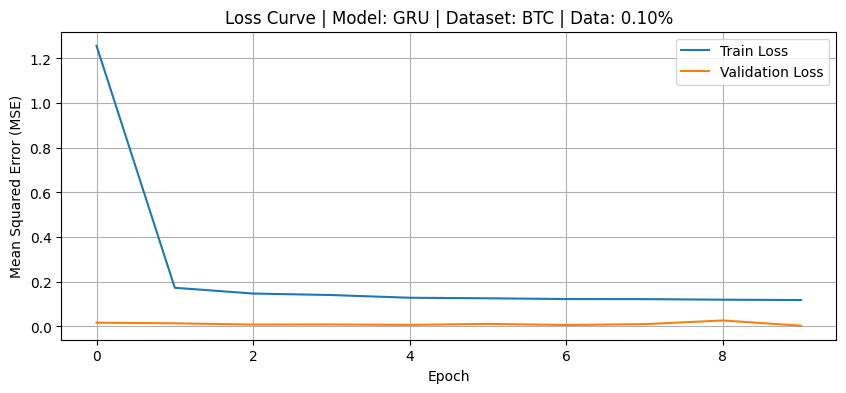

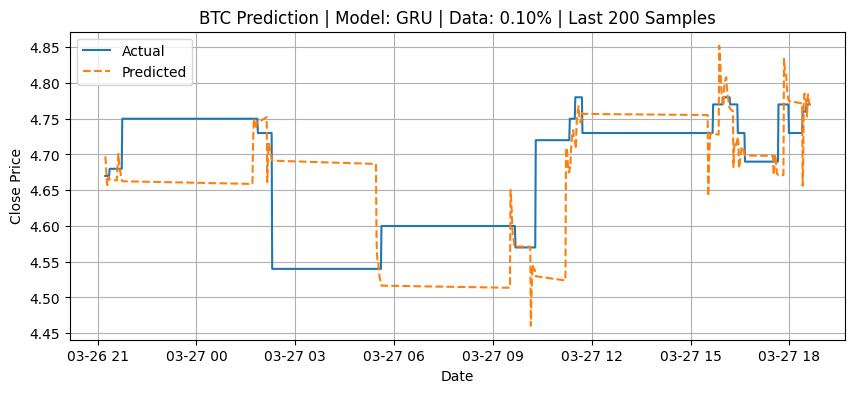

In [135]:
stats_btc_gru = run_full_pipeline(
    asset="btc", 
    model_name = "gru",
    epochs=EPOCHS,
    model_function=build_gru_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

In [27]:
testing_etc = eth_df_features.copy()

In [ ]:
testing_etc['target'] = testing_etc['Close'].shift(-1)

In [55]:
testing_etc.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close_1m_ago',
       'PctChange_1m', 'Close_5m_ago', 'PctChange_5m', 'Close_1h_ago',
       'PctChange_1h', 'Close_1d_ago', 'PctChange_1d', 'Close_1w_ago',
       'PctChange_1w', 'Close_1mo_ago', 'PctChange_1mo', 'SMA_20', 'EMA_20',
       'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200', 'RSI_14', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower',
       'VolMA_short', 'VolMA_long', 'VolumeOscillator', 'OBV', 'candle_range',
       'body_size', 'Doji', 'ATR', '+DI', '-DI', 'ADX', '%K', '%D',
       'Williams_%R', 'target'],
      dtype='object')

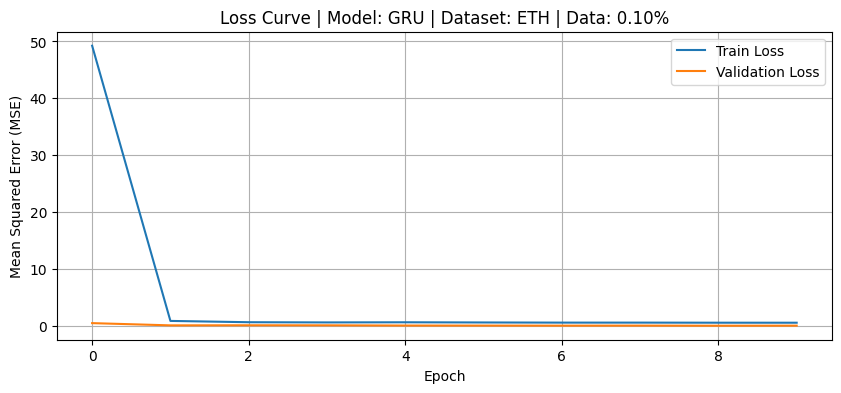

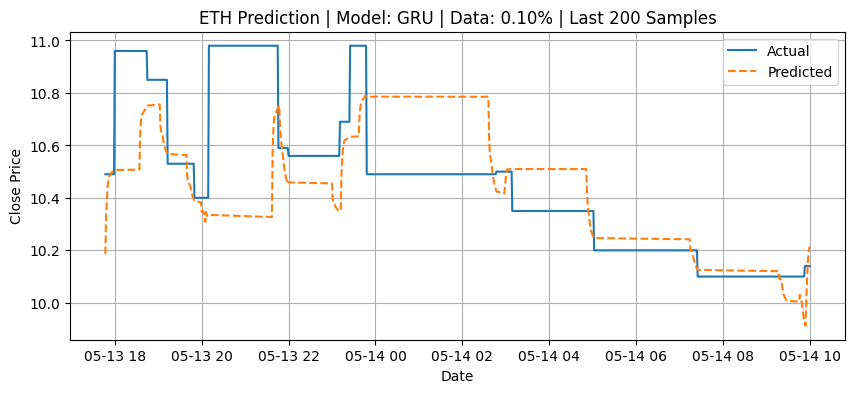

In [136]:
stats_eth_gru = run_full_pipeline(
    asset="eth", 
    model_name = "gru",
    epochs=EPOCHS,
    model_function=build_gru_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

### CNN

> Note: In the initial implementation and runs, we did not include date_series; this was done later, and we ran the CNN BTC for this to test.


In [ ]:
stats_btc_cnn = run_full_pipeline(
    asset="btc", 
    model_name = "cnn",
    epochs=EPOCHS,
    model_function=build_cnn_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

In [ ]:
stats_eth_cnn = run_full_pipeline(
    asset="eth", 
    model_name = "cnn",
    epochs=EPOCHS,
    model_function=build_cnn_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

### Transformer

In [ ]:
stats_btc_transformer = run_full_pipeline(
    asset="btc", 
    model_name = "transformer",
    epochs=EPOCHS,
    model_function=build_transformer_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

In [ ]:
stats_btc_transformer = run_full_pipeline(
    asset="eth", 
    model_name = "transformer",
    epochs=EPOCHS,
    model_function=build_transformer_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

### RNN

The initial files for this got saved into `<function build_rnn_model at 0x7f462719b910>` funtion name. This was later updated to "rnn". Just a mistake but was fixed manually. 


In [ ]:
stats_btc_rnn = run_full_pipeline(
    asset="btc", 
    model_name = "rnn",
    epochs=EPOCHS,
    model_function=build_rnn_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

In [ ]:
stats_eth_rnn = run_full_pipeline(
    asset="eth", 
    model_name = "rnn",
    epochs=EPOCHS,
    model_function=build_rnn_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

We ran into some variable name issues. They have been fixed in the code now, but the names were not consistent. So we ended up renaming the. Here is the code for it:


In [ ]:
import os

def get_new_name(name):
    if name.startswith("<function build_rnn_model"):
        if ">" in name:
            return "rnn" + name.split(">", 1)[-1]
        return "rnn"
    if name.startswith("build_rnn_model"):
        return "rnn" + name[len("build_rnn_model"):]
    return name


def create_mapping(path):
    mapping = {}
    for root, dirs, files in os.walk(path, topdown=False):
        for n in files + dirs:
            new = get_new_name(n)
            if new != n:
                old_path = os.path.join(root, n)
                new_path = os.path.join(root, new)
                mapping[old_path] = new_path
    return mapping

base_path = "./" 
mapping = create_mapping(base_path)

In [ ]:
for old in sorted(mapping, key=len, reverse=True):
    os.rename(old, mapping[old])

---


## Full run

In [143]:
import os
import time
import io
import re
import contextlib
import pandas as pd

def execute_experiment_for_percentage(asset, model_name, model_function, data_pct, epochs, stop_loss, md_base):
    lines = []  
    start = time.time()
    percent_str = format_percent_string(data_pct)
    
    # Capture stdout during run_full_pipeline (and any nested prints)
    stdout_buffer = io.StringIO()
    with contextlib.redirect_stdout(stdout_buffer):
        stats = run_full_pipeline(
            asset=asset,
            model_name=model_name,
            epochs=epochs,
            model_function=model_function,
            data_percent=data_pct,
            stop_loss_pct=stop_loss
        )
    captured_output = stdout_buffer.getvalue()
    # Remove backspace control characters while preserving newlines and normal characters.
    captured_output = re.sub(r'\x08+', '', captured_output)
    duration = time.time() - start

    # Compute artifact file paths.
    training_image_path = os.path.join("plots", f"loss_curve_{model_name}_{asset}_{percent_str}pct.png")
    prediction_plot_path = os.path.join("plots", f"prediction_plot_{model_name}_{asset}_{percent_str}pct.png")
    
    # Use prediction CSV (comparison) instead of the old epoch CSV.
    prediction_csv_path = os.path.join("model-result-data", f"{model_name.lower()}_{asset.lower()}_comparison_{percent_str}pct.csv")
    # Compute the metrics CSV path (as generated in print_metrics).
    metrics_csv_path = os.path.join("model-result-data", f"{asset.lower()}_{model_name.lower()}_{percent_str}pct_metrics.csv")
    stop_str = format_percent_string(stop_loss)
    result_folder = os.path.join(
        "results",
        f"{model_name}_{asset}_{format_percent_string(data_pct)}pct_{stop_str}stloss"
        )
    backtest_html_path = os.path.join(result_folder, "backtest_plot.html")
    backtest_csv_path = os.path.join(result_folder, "backtest_stats.csv")
    model_file = os.path.join("models", f"{model_name}_{asset}_model_{percent_str}pct.h5")
    scaler_file = os.path.join("models", f"{model_name}_{asset}_scaler_{percent_str}pct.pkl")
    
    # Utility: Compute relative paths (using forward slashes).
    def rel_path(p):
        return os.path.relpath(p, start=md_base).replace(os.path.sep, '/')

    # Begin constructing the Markdown snippet.
    lines.append(f"#### Experiment: Data Used: {data_pct:.3%}, Epochs: {epochs}")
    lines.append(f"**Stop Loss:** {stop_loss:.3%}\n")
    lines.append(f"**Duration:** {duration:.2f} seconds\n")
    
    # Console output as a subheading.
    if captured_output.strip():
        lines.append("##### Console Output:")
        lines.append("```\n" + captured_output + "\n```")
    
    # Training Loss Plot as a subheading.
    if os.path.exists(training_image_path):
        lines.append("##### Training Loss Plot:")
        lines.append(f"![Training Loss Plot]({rel_path(training_image_path)})\n")
    
    # Prediction Plot as a subheading.
    if os.path.exists(prediction_plot_path):
        lines.append("##### Prediction Plot:")
        lines.append(f"![Prediction Plot]({rel_path(prediction_plot_path)})\n")
    
    # Comparison CSV link as a subheading.
    if os.path.exists(prediction_csv_path):
        lines.append("##### Comparison Data:")
        lines.append(f"[View CSV]({rel_path(prediction_csv_path)})\n")
    
    # Metrics CSV link as a subheading.
    if os.path.exists(metrics_csv_path):
        lines.append("##### Metrics CSV:")
        lines.append(f"[View CSV]({rel_path(metrics_csv_path)})\n")
    
    # Backtest Interactive Chart as a subheading.
    lines.append("##### Backtest Interactive Chart:")
    if os.path.exists(backtest_html_path):
        # Embed the HTML as an iframe.
        iframe_html = f'<iframe src="{rel_path(backtest_html_path)}" width="100%" height="600px" frameborder="0"></iframe>'
        lines.append(iframe_html)
        lines.append(f"If the iframe does not display, please [click here to view the HTML]({rel_path(backtest_html_path)}).\n")
    else:
        lines.append(f"Backtest interactive chart HTML file not found at {backtest_html_path}\n")
    
    # Backtest Stats as a subheading.
    if os.path.exists(backtest_csv_path):
        lines.append("##### Backtest Stats:")
        try:
            df_csv = pd.read_csv(backtest_csv_path)
            csv_md = df_csv.to_markdown(index=False)
            lines.append(csv_md + "\n")
        except Exception:
            lines.append(f"[View CSV]({rel_path(backtest_csv_path)})\n")
    
    # Saved Model and Scaler as a subheading.
    if os.path.exists(model_file) and os.path.exists(scaler_file):
        lines.append("##### Saved Model and Scaler:")
        lines.append(f"- **Model:** [View Model]({rel_path(model_file)})")
        lines.append(f"- **Scaler:** [View Scaler]({rel_path(scaler_file)})\n")
    
    # Combine all lines into the final markdown snippet.
    markdown_snippet = "\n".join(lines) + "\n\n---\n\n"
    
    # Save the markdown (including the captured output) into a dedicated text file.
    text_log_dir = os.path.join("logs", "experiment_text")
    os.makedirs(text_log_dir, exist_ok=True)
    text_log_file = os.path.join(text_log_dir, f"experiment_{asset}_{model_name}_{percent_str}pct.txt")
    with open(text_log_file, "w") as log_file:
        log_file.write(markdown_snippet)
    
    # Return useful information along with the generated markdown snippet.
    return {
        "stats": stats,
        "markdown": markdown_snippet,
        "comparison_csv": prediction_csv_path,
        "metrics_csv": metrics_csv_path,
        "text_log": text_log_file
    }


In [144]:
def execute_model_runs(models_dict, assets, data_percentages, epochs=10, stop_loss=0.003, display_report=True):
    results = {}
    csv_paths = []
    report_filenames = []
    report_dir = os.path.join("logs", "reports")
    os.makedirs(report_dir, exist_ok=True)
    
    # Loop over each data percentage to create individual reports
    for data_pct in data_percentages:
        report_md_lines = []
        pct_str = format_percent_string(data_pct)
        start_time = time.time()
        
        # Build report header using a more descriptive title.
        report_md_lines.append(f"# Full Analysis Report for Data Percentage: {data_pct * 100:.2f}%\n")
        report_md_lines.append("This report summarizes all experiments conducted for this specific data percentage.\n")
        report_md_lines.append(f"**Assets Tested:** {', '.join(assets)}\n")
        report_md_lines.append(f"**Epochs per Experiment:** {epochs}\n")
        report_md_lines.append(f"**Stop Loss Setting:** {stop_loss}\n")
        report_md_lines.append("---\n")
        
        for asset in assets:
            # Initialize results for the asset if not already present
            if asset not in results:
                results[asset] = {}
            report_md_lines.append(f"\n## Asset: {asset.upper()}\n")
            
            for model_name, model_fn_list in models_dict.items():
                if model_name not in results[asset]:
                    results[asset][model_name] = {}
                report_md_lines.append(f"\n### Model: {model_name.upper()}\n")
                
                for model_fn in model_fn_list:
                    # Execute the experiment for current asset/model/data percentage.
                    exp_result = execute_experiment_for_percentage(
                        asset=asset,
                        model_name=model_name,
                        model_function=model_fn,
                        data_pct=data_pct,
                        epochs=epochs,
                        stop_loss=stop_loss,
                        md_base=report_dir
                    )
                    
                    # Remove unwanted experiment run heading from the returned markdown snippet.
                    exp_markdown_lines = [
                        line for line in exp_result["markdown"].splitlines()
                        if not line.startswith("#### Experiment: Data Used:")
                    ]
                    cleaned_markdown = "\n".join(exp_markdown_lines)
                    
                    # Store the stats in the results dictionary.
                    results[asset][model_name][data_pct] = exp_result["stats"]
                    
                    # Add the cleaned experiment markdown to the report content.
                    report_md_lines.append(cleaned_markdown)
                    
                    # Collect the comparison and metrics CSV paths.
                    csv_paths.append({
                        "asset": asset,
                        "model": model_name,
                        "data_pct": data_pct,
                        "comparison_csv": exp_result["comparison_csv"],
                        "metrics_csv": exp_result["metrics_csv"]
                    })
        
        total_duration = time.time() - start_time
        report_md_lines.append(f"\n---\n**Total Duration for Data Percentage {data_pct * 100:.2f}%:** {total_duration:.2f} seconds\n")
        full_md_content = "\n".join(report_md_lines)
        
        # Create report filename using the formatted percentage.
        report_filename = f"experiment_report_{pct_str}pct.md"
        md_filename = os.path.join(report_dir, report_filename)
        report_filenames.append(md_filename)
        
        with open(md_filename, "w") as f:
            f.write(full_md_content)
        
        if display_report:
            print(full_md_content)
            print(f"\nMarkdown report saved to: {md_filename}\n")
            try:
                display(Markdown(full_md_content))
            except Exception:
                pass

    return results, report_filenames, csv_paths


In [145]:
def conv_md_toc(report_path):
    html_file = os.path.splitext(report_path)[0] + '.html'
    with open(report_path, 'r', encoding='utf-8') as f:
        md_content = f.read()
    lines = md_content.splitlines()
    spaced = []
    for i, line in enumerate(lines):
        spaced.append(line)
        if i < len(lines) - 1 and lines[i].strip() and lines[i+1].strip():
            spaced.append("")
    toc = ("<div style='text-align: center; font-weight: bold; font-size: 1.5em; "
           "font-family: Georgia, serif;'>Table of Content</div>\n\n[TOC]\n\n")
    new_lines = []
    toc_inserted = False
    for line in spaced:
        if not toc_inserted and line.strip() == '---':
            new_lines.append(toc.strip())
            new_lines.append("")
            toc_inserted = True
        new_lines.append(line)
    md_with_toc = "\n".join(new_lines) if toc_inserted else toc + "\n".join(spaced)
    html_body = markdown.markdown(
        md_with_toc,
        extensions=['toc', 'fenced_code', 'tables'],
        extension_configs={'toc': {'permalink': True, 'toc_depth': '2-6', 'title': ''}}
    )
    html_template = f"""<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>Report</title>
    <style>
        body {{
            font-family: Georgia, 'Times New Roman', serif;
            font-size: 16px;
            line-height: 1.6;
            padding: 40px;
            max-width: 800px;
            margin: auto;
        }}
        h1, h2, h3, h4, h5 {{ font-weight: bold; }}
        ul {{ margin-left: 1.5em; }}
        code, pre {{
            font-family: Consolas, monospace;
            background: #f4f4f4;
            padding: 4px;
            border-radius: 4px;
        }}
        .toc ul {{ list-style-type: decimal; padding-left: 20px; }}
    </style>
</head>
<body>
{html_body}
</body>
</html>"""
    with open(html_file, 'w', encoding='utf-8') as f:
        f.write(html_template)
    return html_file

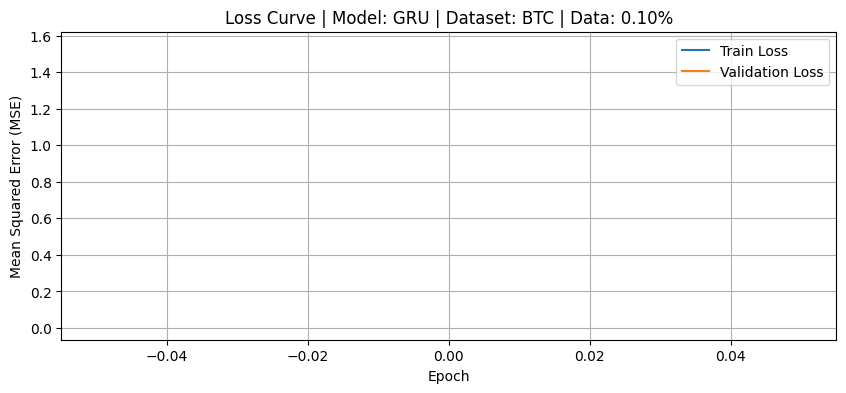

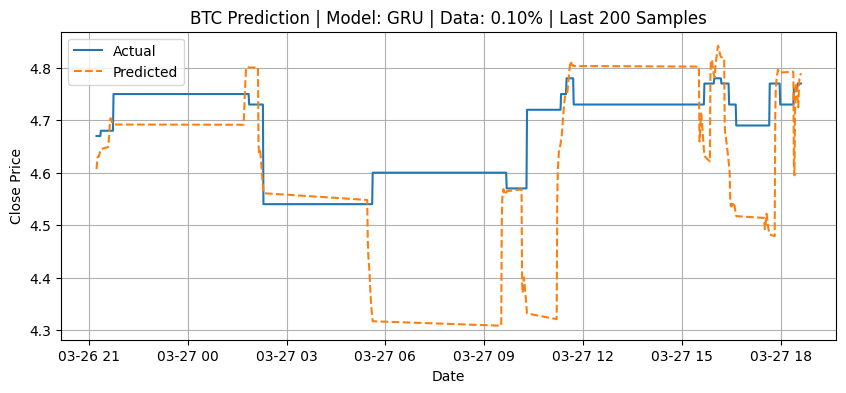

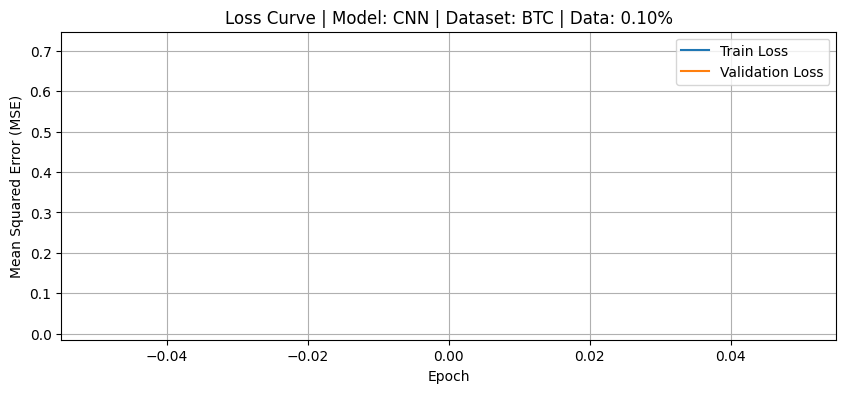

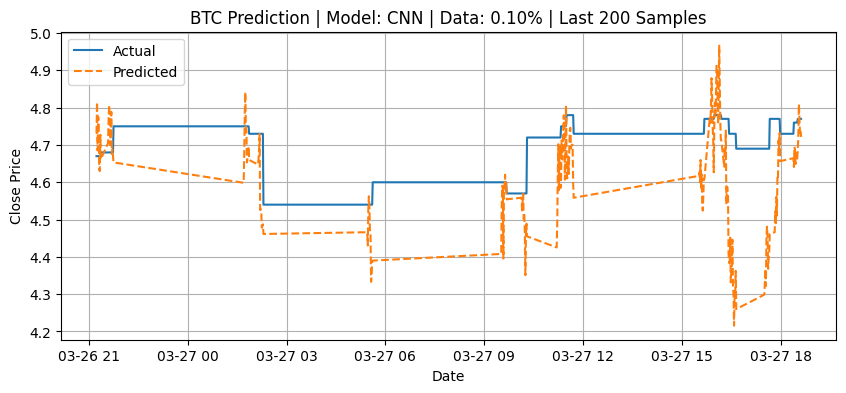

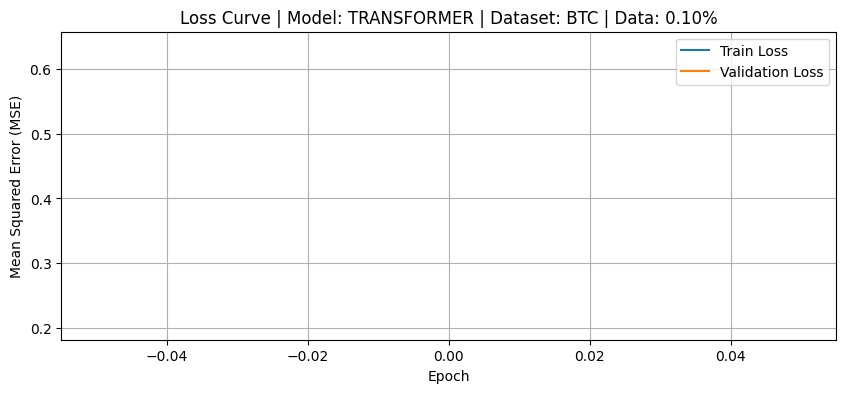

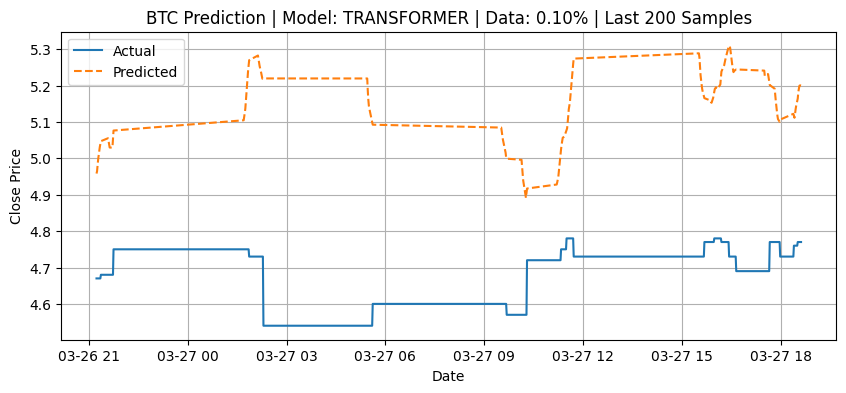

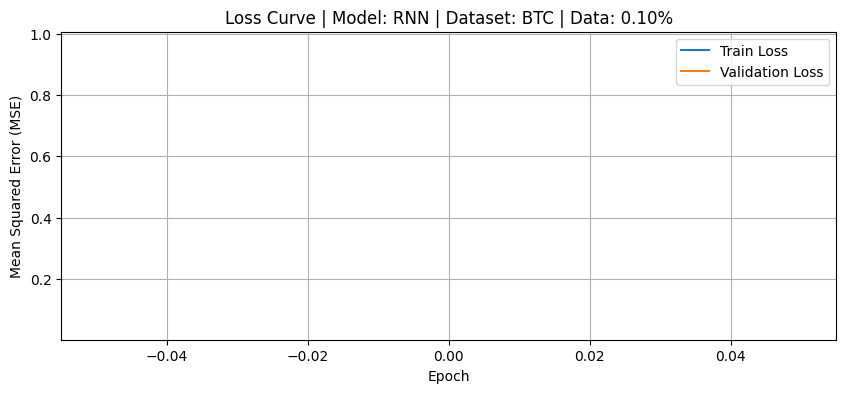

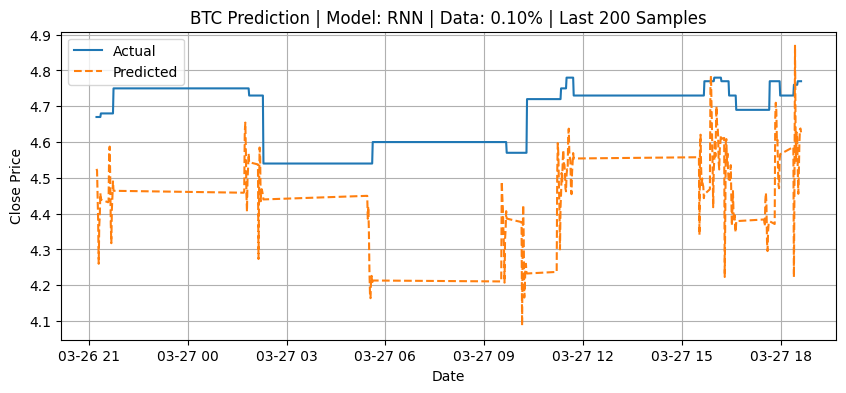

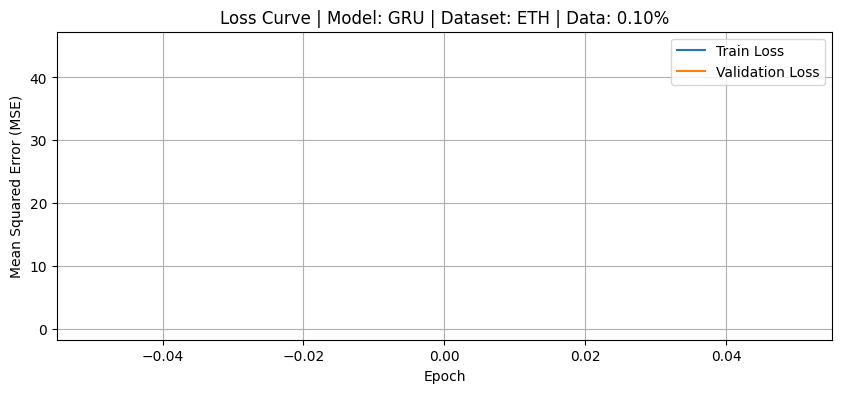

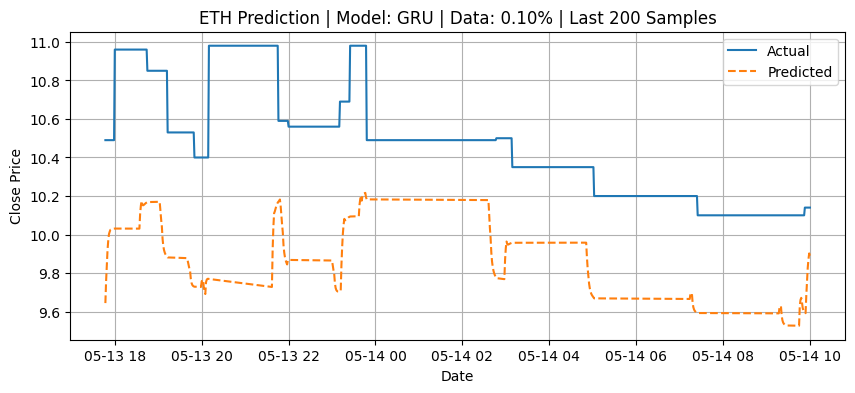

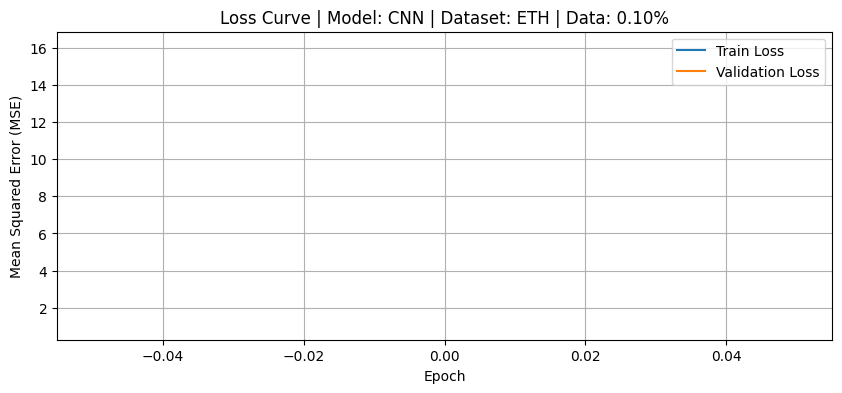

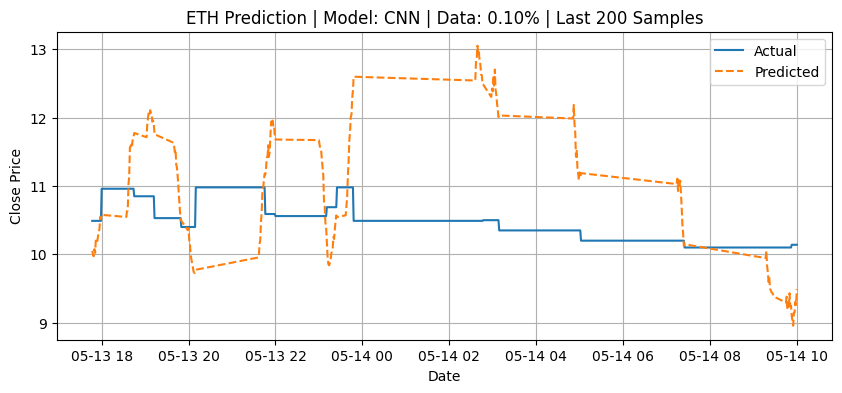

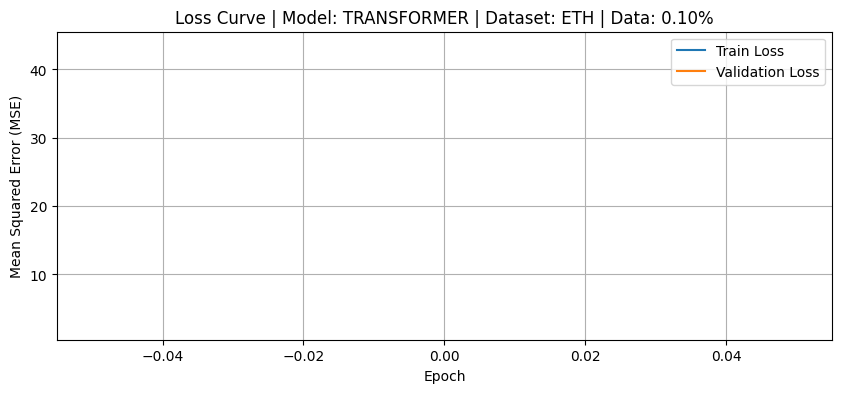

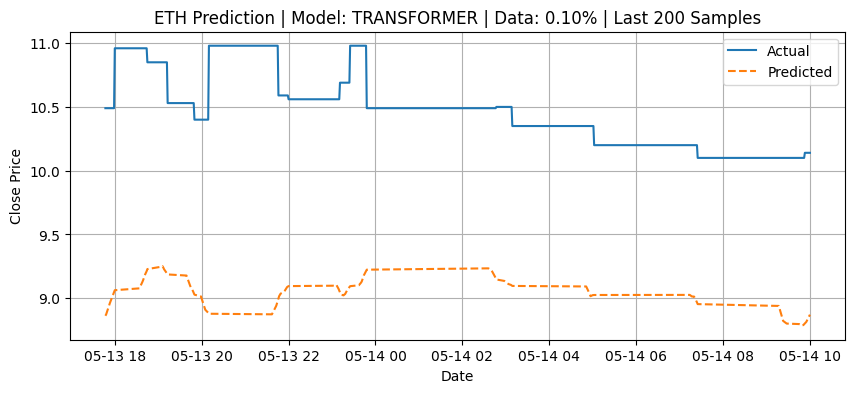

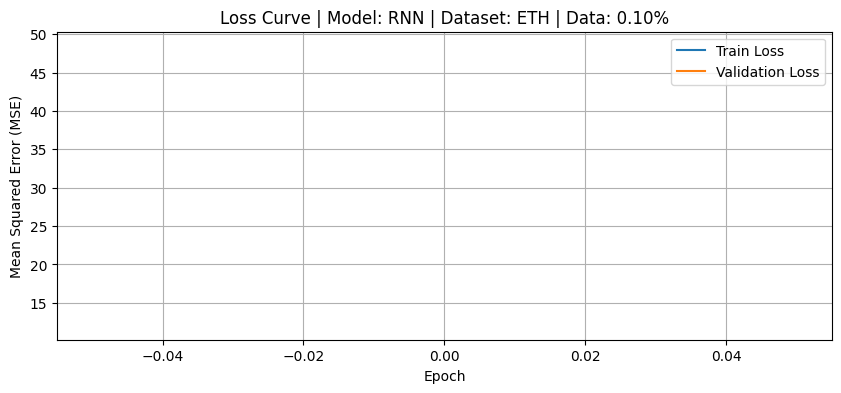

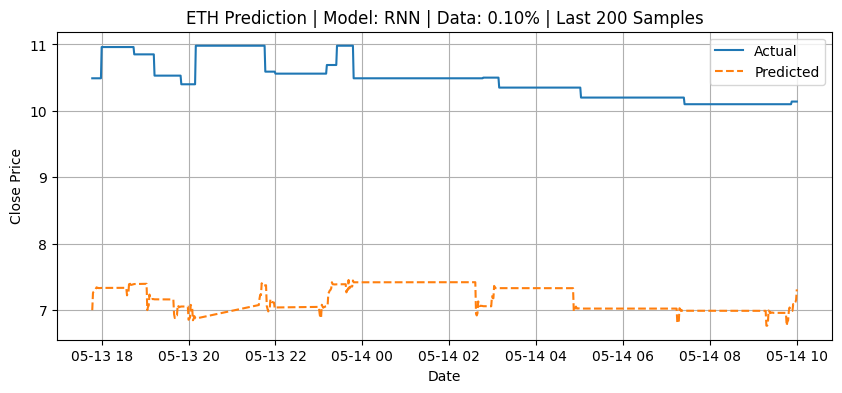

In [146]:
models = {
    "gru": [build_gru_model],
    "cnn": [build_cnn_model],
    "transformer": [build_transformer_model],
    "rnn": [build_rnn_model],
}

ASSETS = ["btc", "eth"]
DATA_PERCENTAGES = [0.001]
EPOCHS = 1
STOP_LOSS = 0.003
results, report_filenames, csv_paths = execute_model_runs(
    models_dict=models,
    assets=ASSETS,
    data_percentages=DATA_PERCENTAGES,
    epochs=EPOCHS,
    stop_loss=STOP_LOSS,
    display_report=False
)

In [147]:
print("Final Experiment Report Generated.\n")
print("Your comprehensive experiment report (with summaries, logs, and artifact links) has been created.\n")
print("Report Links:")
for i, path in enumerate(report_filenames, start=1):
    print(f"  {i}. {path}")


Final Experiment Report Generated.

Your comprehensive experiment report (with summaries, logs, and artifact links) has been created.

Report Links:
  1. logs\reports\experiment_report_0_1pct.md


In [148]:
def conv_all(report_paths):
    html_files = []
    for rpt in report_paths:
        hf = conv_md_toc(rpt)
        print(f"Converted {rpt} -> {hf}")
        html_files.append(hf)
    return html_files

In [149]:
converted_html = conv_all(report_filenames)
print("Converted HTML files:")
for html_file in converted_html:
    print(html_file)

Converted logs\reports\experiment_report_0_1pct.md -> logs\reports\experiment_report_0_1pct.html
Converted HTML files:
logs\reports\experiment_report_0_1pct.html


In [ ]:

def load_logs(log_dir="logs"):
    log_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.endswith(".csv")]
    summary_data = []
    all_logs = []

    for path in log_files:
        df = pd.read_csv(path)
        filename = os.path.basename(path).lower()

        model_match = re.match(r'(.*?)_(btc|eth)_log_(\d{1,2})pct\.csv', filename)
        if not model_match:
            continue

        model_type = model_match.group(1).upper()
        crypto = model_match.group(2).upper()
        data_pct = int(model_match.group(3))

        min_val_loss = df['val_loss'].min()
        min_val_epoch = df['val_loss'].idxmin()
        final_val_loss = df['val_loss'].iloc[-1]
        epochs_run = len(df)

        summary_data.append({
            "Type": model_type,
            "Crypto": crypto,
            "Data %": data_pct,
            "Min Val Loss": min_val_loss,
            "Epoch (Min Val Loss)": min_val_epoch,
            "Final Val Loss": final_val_loss,
            "Epochs Run": epochs_run,
            "File": filename
        })

        df['Model'] = model_type
        df['Crypto'] = crypto
        df['Data %'] = data_pct
        df['File'] = filename
        all_logs.append(df)

    logs_df = pd.concat(all_logs, ignore_index=True)
    summary_df = pd.DataFrame(summary_data).sort_values(by=["Type", "Crypto", "Data %"])
    
    available_pcts = sorted(summary_df["Data %"].unique())
    print("Available Data Percentages:", available_pcts)

    return summary_df, logs_df, available_pcts


summary_df, logs_df, available_pcts = load_logs("logs")
summary_df


ValueError: No objects to concatenate

In [ ]:
def plot_loss_val_loss(logs_df, selected_pct):
    palette = sns.color_palette("tab10")
    model_types = logs_df['Model'].unique()
    color_map = {model: palette[i % len(palette)] for i, model in enumerate(model_types)}

    grouped = logs_df[logs_df["Data %"] == selected_pct].groupby(['Crypto'])

    for crypto, group in grouped:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

        # LOSS subplot
        ax = axes[0]
        for model in model_types:
            model_data = group[group['Model'] == model].sort_values('epoch')
            if not model_data.empty:
                ax.plot(model_data['epoch'], model_data['loss'], label=model, color=color_map[model], linewidth=2)
        ax.set_title(f"Training Loss - {crypto} - {selected_pct}% Data")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()

        # VAL_LOSS subplot
        ax = axes[1]
        for model in model_types:
            model_data = group[group['Model'] == model].sort_values('epoch')
            if not model_data.empty:
                ax.plot(model_data['epoch'], model_data['val_loss'], label=model, color=color_map[model], linewidth=2, linestyle='--')
        ax.set_title(f"Validation Loss - {crypto} - {selected_pct}% Data")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Val Loss")
        ax.grid(True)
        ax.legend()

        plt.tight_layout()
        plt.show()


In [ ]:
selected_pct = 10
plot_loss_val_loss(logs_df, selected_pct)

In [ ]:
plot_loss_val_loss(logs_df, selected_pct=1)

In [ ]:
news_output_file_realistic  = os.path.join(PROCESSED_DATA, "aggregated_realistic_news_with_features.csv.gz")
agg_news_features_df = pd.read_csv(news_output_file_realistic, compression="gzip", index_col="id")


In [ ]:
agg_news_features_df = agg_news_features_df.drop(columns=["minute_floor"])


In [ ]:
min_index = agg_news_features_df.index.min()
max_index = agg_news_features_df.index.max()
print("Min index:", min_index)
print("Max index:", max_index)

Note: We can only use the sentimental side using BTC, as the data we have for ETH does not overlap with ETH.


In [ ]:
def get_boundary_for_percentage(features_df, targets_df, pct):
    common_index = features_df.index.intersection(targets_df.index).sort_values()
    total = len(common_index)
    subset_size = max(int(total * pct), 1)
    return common_index[0], common_index[subset_size - 1]

percentages = [0.01, 0.1]
for pct in percentages:
    start, end = get_boundary_for_percentage(btc_df_features, btc_targets, pct)
    print(f"{pct*100:.0f}% of data: Start = {start}, End = {end}")


This is one of the reasons why we utilized the 10% in the earlier 


In [ ]:
def get_boundary_for_percentage(features_df, targets_df, pct):
    common_index = features_df.index.intersection(targets_df.index).sort_values()
    total = len(common_index)
    subset_size = max(int(total * pct), 1)
    start = common_index[0]
    end = common_index[subset_size - 1]
    print(f"{pct*100:.0f}% of data: Start = {start}, End = {end}")
    return start, end


In [ ]:
start_1, end_1 = get_boundary_for_percentage(btc_df_features, btc_targets, 0.01)
start_10, end_10 = get_boundary_for_percentage(btc_df_features, btc_targets, 0.1)


In [ ]:
start_10 = pd.to_datetime(start_10)
end_10 = pd.to_datetime(end_10)


In [ ]:
agg_news_features_df.index = pd.to_datetime(agg_news_features_df.index)

news_data_df = agg_news_features_df.loc[
    (agg_news_features_df.index >= start_10) &
    (agg_news_features_df.index <= end_10)]

In [ ]:
analysis_data = news_data_df.merge(
    btc_df_features[['Close']], left_index=True, right_index=True, how='inner'
)

analysis_data = analysis_data.rename(columns={'sentiment_score_mean': 'news_sentiment'})


In [ ]:
analysis_data['btc_next_min_change'] = (
    analysis_data['Close'].shift(-1) / analysis_data['Close'] - 1
)


In [ ]:
def classify_news(score, pos_threshold=0.55, neg_threshold=0.45):
    if score > pos_threshold:
        return 1
    elif score < neg_threshold:
        return -1
    return 0

def classify_btc(change):
    if change > 0:
        return 1
    elif change < 0:
        return -1
    return 0

analysis_data['predicted_sentiment'] = analysis_data['news_sentiment'].apply(classify_news)
analysis_data['actual_movement'] = analysis_data['btc_next_min_change'].apply(classify_btc)


In [ ]:

labels = [-1, 0, 1]
label_names = ['Negative', 'Neutral', 'Positive']


cm = confusion_matrix(
    analysis_data['actual_movement'],
    analysis_data['predicted_sentiment'],
    labels=labels
)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Movement')
plt.title('Confusion Matrix (BTC vs News Sentiment)')
plt.tight_layout()
plt.show()


In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Purples',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Movement')
plt.title('Confusion Matrix (Percentage)')
plt.tight_layout()
plt.show()


In [ ]:
print("\nClassification Report:")
print(classification_report(
    analysis_data['actual_movement'],
    analysis_data['predicted_sentiment'],
    labels=[-1, 0, 1]
))

## Combined

### Getting data from all of the models

Since we are using 10% we can skip the analysis with anything else. 


We can just slice the data in the same way because the models use the first 10% of the time-sorted index during training. This ensures we're pulling the exact same chronological data used across all model comparisons.


In [15]:
common_idx = btc_df_features.index.intersection(btc_targets.index).sort_values()
subset_dates = common_idx[:int(len(common_idx) * DATA_PERCENT)]

btc_data_10_df = btc_df_features.loc[subset_dates].copy()
btc_data_10_df["timestamp"] = pd.to_datetime(btc_data_10_df.index)

min_idx = btc_data_10_df.index.min()
max_idx = btc_data_10_df.index.max()

print("Min index:", min_idx)
print("Max index:", max_idx)

Min index: 0
Max index: 628345


In [ ]:
X_raw, y_raw, _, _ = get_data_subset(btc_df_features, btc_targets, "btc_Close_1m_later", data_percent=DATA_PERCENT)

In [ ]:
X_scaled, scaler = scale_features(X_raw)
y_raw_values = y_raw.values
X_seq, y_seq, all_indices = create_sequences(X_scaled, y_raw_values, time_steps=30)
X_train, y_train, X_test, y_test, idx_train, idx_test = train_test_split_sequences(
    X_seq, y_seq, all_indices, train_ratio=0.8
)


In [ ]:
print("btc_df_features index type:", type(btc_df_features.index))
print("btc_df_features index dtype:", btc_df_features.index.dtype)
print("btc_df_features index sample:", btc_df_features.index[:5])

print("X_raw index type:", type(X_raw.index))
print("X_raw index dtype:", X_raw.index.dtype)
print("X_raw index sample:", X_raw.index[:5])


In [ ]:
all_test_index_in_btc_df = X_raw.index[idx_test].strftime('%Y%m%d%H%M').astype(int)
df_test = btc_df_features.loc[all_test_index_in_btc_df].drop_duplicates().sort_index()
idx_to_target = {}
for seq_num, start_i in enumerate(idx_test):
    last_pos = start_i + 29
    if last_pos < len(X_raw):
        # Convert from position (last_pos) to the original dataframe index
        last_row_index = X_raw.index[last_pos]
        idx_to_target[last_row_index] = y_test[seq_num]

target_series = pd.Series(idx_to_target, name="btc_Close_1m_later")

btc_df_test_with_target = df_test.join(target_series, how="left")


In [ ]:
selected_percentage = 0.1
pct_str = "10pct" if selected_percentage == 0.1 else "1pct"

# Gather all BTC CSV files matching either "10pct" or "1pct" naming
result_files = [
    f for f in os.listdir(RESULT_DATA_DIR)
    if f.endswith(f"{pct_str}.csv") and "btc" in f.lower()
]
print(f"Found {len(result_files)} BTC result file(s) for {pct_str}.")

df_list = []

for file in result_files:
    print(f"Loading: {file}")
    df = pd.read_csv(os.path.join(RESULT_DATA_DIR, file))

    # Clean up column names
    df.columns = [col.strip().lower() for col in df.columns]

    # Grab model name from filename (everything before the first underscore).
    match = re.match(r'(.*?)_', file)
    model_name = match.group(1).lower() if match else "unknown"

    # 1) Rename "actual" to "actual_{model_name}" (unless model is x or y)
    if "actual" in df.columns and model_name not in ["x", "y"]:
        df.rename(columns={"actual": f"actual_{model_name}"}, inplace=True)

    # 2) Rename the predicted column(s) to something model-specific
    #    E.g. rename "predicted" or any single column with "pred" in the name
    pred_cols = [c for c in df.columns if "pred" in c or c == "predicted"]
    if len(pred_cols) == 1:
        df.rename(columns={pred_cols[0]: f"{model_name}_predicted"}, inplace=True)

    # Drop old DataFrame index and use 0..N-1 for alignment
    df.reset_index(drop=True, inplace=True)

    print(f"  Shape: {df.shape}")
    df_list.append(df)

merged_predictions_df = pd.concat(df_list, axis=1)

# Optionally add a new index-based ID column
merged_predictions_df.insert(0, 'new_id', merged_predictions_df.index)

print("Final Merged DataFrame Shape:", merged_predictions_df.shape)
print("Final Merged DataFrame Columns:", list(merged_predictions_df.columns))


In [ ]:
actual_cols = [col for col in merged_predictions_df.columns if "actual" in col]
if actual_cols:
    first_actual = actual_cols[0]
    merged_predictions_df.rename(columns={first_actual: "target"}, inplace=True)


In [ ]:
cols_to_drop = [
    col for col in merged_predictions_df.columns
    if "actual_" in col or col.startswith("unnamed:")
]


In [ ]:
merged_predictions_df.drop(columns=cols_to_drop, inplace=True)

print("Remaining columns:", merged_predictions_df.columns.tolist())


In [ ]:
merged_predictions_df.drop(columns=["new_id"], inplace=True)


In [ ]:
# Print the shape of btc_df_test_with_target
print("Shape of btc_df_test_with_target:", btc_df_test_with_target.shape)

# Print the shape of merged_predictions_df
print("Shape of merged_predictions_df:", merged_predictions_df.shape)


In [ ]:
btc_df_test_with_target.drop(columns=["minute_id"], inplace=True)


In [ ]:
merged_predictions_df["date"] = (
    pd.to_datetime(merged_predictions_df["date"], errors="coerce")
      .dt.strftime("%Y%m%d%H%M")
)

# %%
merged_predictions_df["date"]

# %%
btc_df_test_with_target['date'] = btc_df_test_with_target.index.astype(str)


# %%
btc_df_test_with_target["date"] = (
    pd.to_datetime(btc_df_test_with_target["date"], errors="coerce")
      .dt.strftime("%Y%m%d%H%M")
)

In [ ]:
btc_df_test_with_target

In [ ]:
df_test_predictions_merged = (
    pd.merge(
        btc_df_test_with_target,
        merged_predictions_df,
        left_on="date",
        right_on="date",
        how="inner"
    )
    .set_index("date")
)



In [ ]:
df_test_predictions_merged.drop(columns=["btc_Close_1m_later"], inplace=True)


In [ ]:
output_file = os.path.join(PROCESSED_DATA, "btc_test_predictions_with_features.csv.gz")
df_test_predictions_merged.to_csv(output_file, compression="gzip")
